In [3]:
## Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from xgboost import XGBRegressor, plot_importance
import ast

In [4]:
## Загрузка и базовый осмотр
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (4548, 28)
Test shape: (1516, 27)


In [5]:
## Удалим лишние столбцы
train.drop(columns=['Unnamed: 0', 'ФИО'], inplace=True)
test.drop(columns=['Unnamed: 0', 'ФИО'], inplace=True)

In [6]:
## Предмет — one-hot
subject_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
subjects_train = subject_ohe.fit_transform(train[['предмет']])
subjects_test = subject_ohe.transform(test[['предмет']])

subj_cols = subject_ohe.get_feature_names_out(['предмет'])
train[subj_cols] = subjects_train
test[subj_cols] = subjects_test

train.drop(columns=['предмет'], inplace=True)
test.drop(columns=['предмет'], inplace=True)

In [7]:
## Тэги профиля (мульти-классовые)
train['tutor_head_tags'] = train['tutor_head_tags'].map(ast.literal_eval)
test['tutor_head_tags'] = test['tutor_head_tags'].map(ast.literal_eval)

tag_binarizer = MultiLabelBinarizer()
tag_binarizer.fit(train['tutor_head_tags'])

train_tags = pd.DataFrame(tag_binarizer.transform(train['tutor_head_tags']), columns=tag_binarizer.classes_)
test_tags = pd.DataFrame(tag_binarizer.transform(test['tutor_head_tags']), columns=tag_binarizer.classes_)

train = pd.concat([train.drop(columns=['tutor_head_tags']), train_tags], axis=1)
test = pd.concat([test.drop(columns=['tutor_head_tags']), test_tags], axis=1)


In [8]:
## Признаки: tutor_rating, reviews
train['tutor_rating'].fillna(0, inplace=True)
test['tutor_rating'].fillna(0, inplace=True)

<ipython-input-8-21e19afe5964>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['tutor_rating'].fillna(0, inplace=True)
<ipython-input-8-21e19afe5964>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [9]:
## Binary-флаги: description и experience_desc
for col in ['description', 'experience_desc']:
    for df in [train, test]:
        df[col] = df[col].fillna("").apply(lambda x: 0 if x.startswith("Репетитор не предоставил") or x == "" else 1)

In [10]:
## Образование и ученые степени
edu_cols = [col for col in train.columns if 'Education' in col or 'Учен' in col or 'Desc_Education' in col]

for df in [train, test]:
    df[edu_cols] = df[edu_cols].notna().astype(int)


In [11]:
## Статус — one-hot на запятую
status_dummies = train['status'].str.get_dummies(sep=",")
status_dummies_test = test['status'].str.get_dummies(sep=",")
train = pd.concat([train.drop(columns=['status']), status_dummies], axis=1)
test = pd.concat([test.drop(columns=['status']), status_dummies_test], axis=1)


In [12]:
## Experience в числовой формат
for df in [train, test]:
    df['experience'] = df['experience'].str.extract(r'(\d+)').fillna(0).astype(int)

In [13]:
## Категории учеников — multilabel
train['categories'] = train['categories'].map(ast.literal_eval)
test['categories'] = test['categories'].map(ast.literal_eval)

cat_binarizer = MultiLabelBinarizer()
cat_binarizer.fit(train['categories'])

train_cats = pd.DataFrame(cat_binarizer.transform(train['categories']), columns=cat_binarizer.classes_)
test_cats = pd.DataFrame(cat_binarizer.transform(test['categories']), columns=cat_binarizer.classes_)

train = pd.concat([train.drop(columns=['categories']), train_cats], axis=1)
test = pd.concat([test.drop(columns=['categories']), test_cats], axis=1)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Студенты университетов группа'] will be ignored
  warnings.warn(


In [14]:
## Целевая переменная и выбросы (3 сигмы)
y = train['mean_price']
X = train.drop(columns=['mean_price'])

z_scores = ((y - y.mean()) / y.std()).abs()
outliers = z_scores > 3
X = X[~outliers]
y = y[~outliers]

In [15]:
## Масштабирование числовых признаков
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)


In [16]:
## Разделение на train/test
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25, random_state=42)


In [17]:
## Обучение SVR с GridSearchCV
param_grid = {
    'C': [1, 5, 10, 50],
    'gamma': [0.1, 0.2, 0.4, 0.8],
    'epsilon': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring='neg_mean_squared_error', cv=3, verbose=0)
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_
val_preds_svr = best_svr.predict(X_val)
mse_svr = mean_squared_error(y_val, val_preds_svr)


In [18]:
## Обучение XGBoost
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.08, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
val_preds_xgb = xgb_model.predict(X_val)
mse_xgb = mean_squared_error(y_val, val_preds_xgb)

print(f"\n📊 Сравнение моделей:")
print(f"SVR MSE: {mse_svr:.4f}")
print(f"XGBoost MSE: {mse_xgb:.4f}")


📊 Сравнение моделей:
SVR MSE: 72.9717
XGBoost MSE: 70.8346


XGBoost показал лучший результат по метрике Mean Squared Error (что и требуется в соревновании). Поэтому он и был выбран как финальная модель.

<ipython-input-19-22c519b70f18>:5: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-19-22c519b70f18>:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


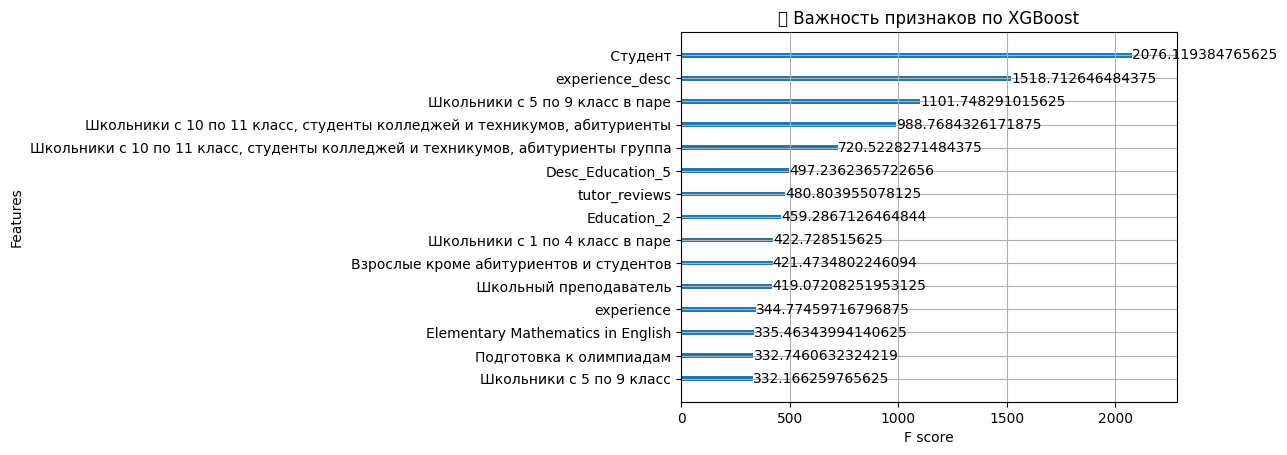

In [19]:
## Визуализация важности признаков XGBoost
plt.figure(figsize=(12, 6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("🔥 Важность признаков по XGBoost")
plt.tight_layout()
plt.show()


Тип важности 'gain': насколько признак уменьшает ошибку, когда используется для разбиения.

Самые важные признаки:

Студент — влияет сильнее всего (возможно, студенты берут дешевле).

experience_desc — если у репетитора есть подробный опыт, это увеличивает цену.

Школьники с 5 по 9 класс в паре — видимо, групповые занятия дешевле или дороже.

Школьники 10-11 класс — уровень подготовки тоже влияет.

tutor_reviews — логично: больше отзывов - Дороже.

In [20]:
## Выбор лучшей модели и предсказание
final_model = best_svr if mse_svr < mse_xgb else xgb_model
final_preds = final_model.predict(test_scaled)

if 'id' in test.columns:
    ids = test['id']
else:
    ids = test.index

submission = pd.DataFrame({
    'index': ids,
    'mean_price': final_preds
})

submission.to_csv("submission.csv", index=False)


📁 submission.csv успешно сохранён.


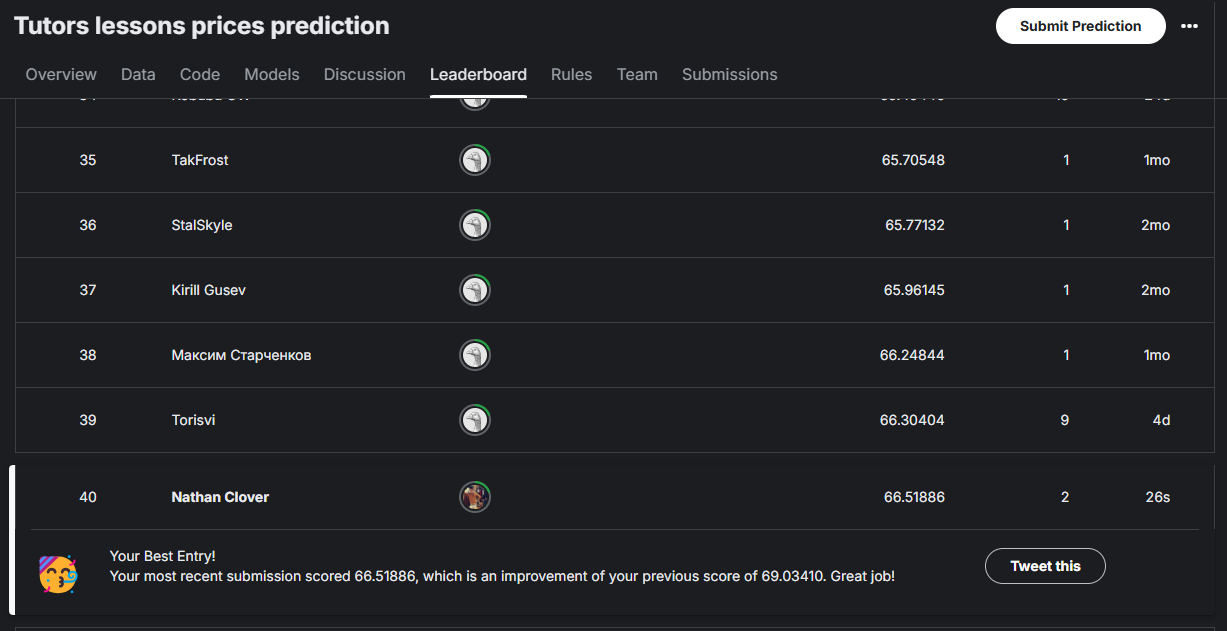